# Exercício de fixação de conceitos 1

## Objetivo

O objetivo desse Jupyter Notebook é exercitar conceitos de Aprendizado de Máquina ligados essencialmente à Regressão Linear, dentre eles:

- Cross Validation
- K-fold
- Critério de Root Mean Square Error (RMSE)
- Regressor Linear ótimo em forma fechada
- Ridge regression
- Mapeamentos não-lineares em regressão linear

## Problema abordado

O problema a ser trabalhado consite em predizer o número de manchas solares em uma série temporal. O datasheet fornecido contém dados mensais de manchas solares desde o ano de 1749 até 2019.

## Importação de bibliotecas


In [1]:
import pandas as pd
import math
import numpy as np
from numpy import genfromtxt
from numpy import linalg
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


Leitura dos dados a partir da planilha em excel:

In [2]:
manchas = genfromtxt('monthly-sunspots.csv', delimiter=',')

Exclusão das colunas de índice e data:

In [3]:
manchas = np.delete(manchas,np.s_[0:2],axis=1)
manchas = np.delete(manchas,0,axis=0)

Visualisação dos dados de manchas solares:

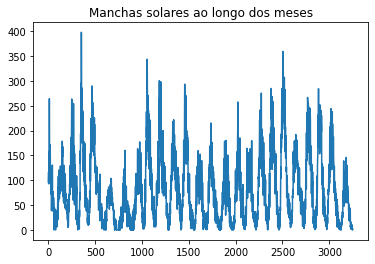

In [4]:
plt.plot(manchas)
plt.title("Manchas solares ao longo dos meses")
plt.show()

## Parte 1 

Montagem da matriz de entrada e do vetor de saídas esperadas:



In [5]:
K = 24
X = toeplitz(manchas[::-1]) # matriz de entrada
y = manchas[K:] # vetor de saída
N = len(y)
print(X)
print(y)

[[  1.6   0.5   0.4 ... 116.7 104.3  96.7]
 [  0.5   1.6   0.5 ...  92.8 116.7 104.3]
 [  0.4   0.5   1.6 ... 141.7  92.8 116.7]
 ...
 [116.7  92.8 141.7 ...   1.6   0.5   0.4]
 [104.3 116.7  92.8 ...   0.5   1.6   0.5]
 [ 96.7 104.3 116.7 ...   0.4   0.5   1.6]]
[[116.7]
 [ 72.5]
 [ 75.5]
 ...
 [  0.4]
 [  0.5]
 [  1.6]]


In [6]:
XL = X[:,:K]
XL = XL[::-1]
XL = XL[:-K]
XL

array([[ 96.7, 104.3, 116.7, ..., 109.5, 105.5, 125.7],
       [104.3, 116.7,  92.8, ..., 105.5, 125.7, 116.7],
       [116.7,  92.8, 141.7, ..., 125.7, 116.7,  72.5],
       ...,
       [ 13.2,   5.7,   8.2, ...,   0.9,   0.5,   1.1],
       [  5.7,   8.2,   6.8, ...,   0.5,   1.1,   0.4],
       [  8.2,   6.8,  10.7, ...,   1.1,   0.4,   0.5]])

Obteve-se uma matriz de entrada XL com 24 colunas e número de linhas igual ao número de dados menos 24.

Divisão dos dados em grupo de treinamento e grupo de teste (5 anos ou 120 meses):

In [7]:
Xtest = XL[-120:,:]
ytest = y[-120:,:]
Xtrain = XL[:-120,:]
ytrain = y[:-120,:]

Definisão da função rmse:

In [8]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Exercício computacional 01

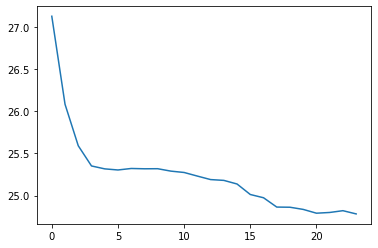

In [9]:
n_splits_kfold = 4
kf = KFold(n_splits = n_splits_kfold)

rmse_vec = np.zeros(K)
for j in range(K,0,-1):
    Xtrain_subset = Xtrain[:,j-1:]
    
    rmse_acc = 0 

    for train_index, test_index in kf.split(Xtrain_subset):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kfold, X_test_kfold = Xtrain_subset[train_index], Xtrain_subset[test_index]
        y_train_kfold, y_test_kfold = ytrain[train_index], ytrain[test_index]
        
        reg = LinearRegression(fit_intercept=True).fit(X_train_kfold, y_train_kfold)
        ypred_kfold = reg.predict(X_test_kfold)
        rmse_acc += rmse(y_test_kfold, ypred_kfold)
    
    rmse_vec[K-j] = rmse_acc/n_splits_kfold
    #print(rmse_acc, rmse_vec[K-k])

plt.plot(rmse_vec)

best_k = rmse_vec.argmin() + 1



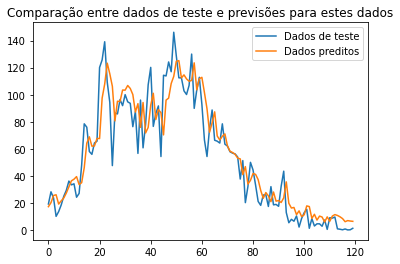

In [10]:
Xtrain_final = Xtrain[:,-best_k:]
Xtest_final = Xtest[:,-best_k:]
reg_final = LinearRegression(fit_intercept=True).fit(Xtrain_final, ytrain)
ypred_test = reg_final.predict(Xtest_final)
rmse_final = rmse(ytest, ypred_test)
rmse_final
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test,label = 'Dados preditos')
plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()


# Exercício computacional 02


In [11]:
K2 = 8
Xtrain2 = Xtrain[:,-K2:]
Xtest2 = Xtest[:,-K2:]
print(Xtrain2.shape)
print(Xtest2.shape)

(3108, 8)
(120, 8)


## Normalização da série

Por se tratar da predição de uma série temporal, pode-se normalizar tudo com base no Xtest, já que tanto as variáveis dependentes quanto as independentes estão na mesma ordem de grandeza.

In [12]:
mean_norm = Xtrain2.mean()
std_norm = Xtrain2.std()
nstd = 4
Xtrain2_norm = (Xtrain2 - mean_norm)/(nstd*std_norm)
Xtest2_norm = (Xtest2 - mean_norm)/(nstd*std_norm)
ytrain2_norm = (ytrain - mean_norm)/(nstd*std_norm)
ytest2_norm = (ytest - mean_norm)/(nstd*std_norm)

(array([1056.,  693.,  527.,  355.,  250.,  139.,   64.,   19.,    3.,
           2.]),
 array([-1.21106419, -0.62943401, -0.04780383,  0.53382635,  1.11545653,
         1.69708671,  2.27871689,  2.86034707,  3.44197725,  4.02360744,
         4.60523762]),
 <BarContainer object of 10 artists>)

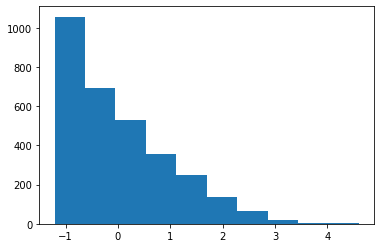

In [13]:
plt.hist(Xtrain2_norm[:,0])

## Estruturação da matriz de combinação W com T vetores gerados aleatoriamente

In [14]:
n_splits_kfold2 = 4
kf2 = KFold(n_splits = n_splits_kfold2)
lambvec = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
Tvec = np.linspace(1,100,100)
result = np.zeros([len(Tvec),len(lambvec)])

for t in range(len(Tvec)):

    for lambridge in range(len(lambvec)):
        w = np.random.rand(K2,t+1)
        wXtrainL = np.tanh((w.T@Xtrain2_norm.T).T)

        rmseT = 0
        
        for train_index, test_index in kf2.split(Xtrain2_norm):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kfold2, X_test_kfold2 = wXtrainL[train_index], wXtrainL[test_index]
            y_train_kfold2, y_test_kfold2 = ytrain2_norm[train_index], ytrain2_norm[test_index]
            
            reg2 = Ridge(alpha = lambvec[lambridge],fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
            y_pred_kfold2 = reg2.predict(X_test_kfold2)

            y_test_kfold2 = y_test_kfold2*nstd*std_norm + mean_norm
            y_pred_kfold2 = y_pred_kfold2*nstd*std_norm + mean_norm

            rmseT += rmse(y_test_kfold2, y_pred_kfold2)
        result[t,lambridge] = rmseT/n_splits_kfold2
        print(lambvec[lambridge],t,result[t,lambridge]) 
    

0.001 0 39.59324371084235
0.01 0 39.59324256710852
0.1 0 39.593231229695434
1.0 0 39.593127837581484
10.0 0 39.59308168832034
100.0 0 39.681651335995525
1000.0 0 44.06441059374137
0.001 1 40.57339095523585
0.01 1 40.57335428006037
0.1 1 40.57299214008312
1.0 1 40.56980748214386
10.0 1 40.56503266055192
100.0 1 40.718776927763436
1000.0 1 42.316059454075166
0.001 2 39.189018430183815
0.01 2 39.188943597067166
0.1 2 39.188248235168686
1.0 2 39.185495400823555
10.0 2 39.25358330237602
100.0 2 39.59435182407948
1000.0 2 40.67868322580648
0.001 3 38.07737862293533
0.01 3 38.07711398455647
0.1 3 38.07495184815802
1.0 3 38.08965518625277
10.0 3 38.776027637853495
100.0 3 40.17545597914501
1000.0 3 41.051515824850384
0.001 4 34.09131512450254
0.01 4 34.09103919986784
0.1 4 34.08886977297986
1.0 4 34.11147713883565
10.0 4 35.04635678248873
100.0 4 37.94673551820723
1000.0 4 39.7456207199425
0.001 5 36.00079764892797
0.01 5 36.00027174887117
0.1 5 35.99745075540611
1.0 5 36.092760541884246
10.0 

In [17]:
print(result)
result.shape

[[39.59324371 39.59324257 39.59323123 39.59312784 39.59308169 39.68165134
  44.06441059]
 [40.57339096 40.57335428 40.57299214 40.56980748 40.56503266 40.71877693
  42.31605945]
 [39.18901843 39.1889436  39.18824824 39.1854954  39.2535833  39.59435182
  40.67868323]
 [38.07737862 38.07711398 38.07495185 38.08965519 38.77602764 40.17545598
  41.05151582]
 [34.09131512 34.0910392  34.08886977 34.11147714 35.04635678 37.94673552
  39.74562072]
 [36.00079765 36.00027175 35.99745076 36.09276054 37.07789082 39.05349778
  40.22876874]
 [37.25790963 37.25765231 37.25525496 37.24477444 37.49191352 39.21520887
  40.61355285]
 [34.75910725 34.75899454 34.75824012 34.77607241 35.44412126 38.15764493
  40.02868987]
 [37.21585467 37.2156123  37.21573734 37.32076418 38.73342928 40.57738932
  41.2108611 ]
 [34.76965944 34.76977044 34.77429114 34.85865336 35.97302903 38.73518414
  40.29159401]
 [34.15064498 34.14598641 34.15012654 34.73052402 36.16729978 38.57984807
  40.24255715]
 [34.73158954 34.7307

(100, 7)